In [12]:
import pandas as pd
from rs3.seq import predict_seq
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

import gpplot as gpp
gpp.set_aesthetics()

Looking at active vs inactive guides in TP53 tiling data and seeing if they separate by RS3 score

In [13]:
#Reading in all data that will be used

# Z-scores from activity-based selection TP53 screen etoposide arm
ABE= pd.read_excel("../../required_data/TP53/ABE_activity_zscores.xlsx",sheet_name="Sheet1")
CBE= pd.read_excel("../../required_data/TP53/CBE_activity_zscores.xlsx",sheet_name="Sheet1")

#subset to positive controls: guides that introduce missense, nonsense, or splice site mutations 
poscon_mutations=["Missense","Nonsense","Splice site"]

ABE=ABE[ABE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)
CBE=CBE[CBE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)

#further subset to positive controls: remove guides that introduce benign mutations
#this reduces the chance that guides are falsely called inactive due to lack of depletion
ABE_benign_guides=pd.read_csv("../../required_data/TP53/ABE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
ABE=ABE[ABE["sgRNA Target Sequence"].isin(ABE_benign_guides)==False].reset_index(drop=True)
CBE_benign_guides=pd.read_csv("../../required_data/TP53/CBE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
CBE=CBE[CBE["sgRNA Target Sequence"].isin(CBE_benign_guides)==False].reset_index(drop=True)

#retrieve guide-level beagle output to obtain the context sequences associated with each guide
ABE_guide_beagle_output=pd.read_table("../../required_data/TP53/tp53_ABE_3_9-guides.txt",usecols=['sgRNA Sequence', 'sgRNA Context Sequence'])
CBE_guide_beagle_output=pd.read_table("../../required_data/TP53/tp53_CBE_3_9-guides.txt",usecols=['sgRNA Sequence', 'sgRNA Context Sequence'])



In [14]:
def plot_active_inactive(z_cutoff,ax):
    #inactive guides
    ABE_inactive=ABE[(ABE["Eto_RepAB_D21;z-score"]>=-z_cutoff)&(ABE["Eto_RepAB_D21;z-score"]<=z_cutoff)]["sgRNA Target Sequence"].tolist()
    CBE_inactive=CBE[(CBE["Eto_RepAB_D21;z-score"]>=-z_cutoff)&(CBE["Eto_RepAB_D21;z-score"]<=z_cutoff)]["sgRNA Target Sequence"].tolist()
    
    #active guides
    ABE_active=ABE[ABE["Eto_RepAB_D21;z-score"]<-z_cutoff]["sgRNA Target Sequence"].tolist()
    CBE_active=CBE[CBE["Eto_RepAB_D21;z-score"]<-z_cutoff]["sgRNA Target Sequence"].tolist()
    
    conflicting_guides= [guide for guide in ABE_active if guide in CBE_inactive]
    conflicting_guides= conflicting_guides+ [guide for guide in CBE_active if guide in ABE_inactive]
    print( len(conflicting_guides),"guides removed due to inconsistent active/inactive classification across ABE and CBE")
    
    active_guides=ABE_active + CBE_active
    #remove duplicates and guides that are inactive in one or the other
    active_guides=list(set([guide for guide in active_guides if guide not in conflicting_guides]))
    
    inactive_guides=ABE_inactive + CBE_inactive
    #remove duplicates and guides that are active in one or the other
    inactive_guides=list(set([guide for guide in inactive_guides if guide not in conflicting_guides]))
    
    
    #get context sequences of active and inactive guides as input for RS3 predictions 
    active_guide_context_sequences=ABE_guide_beagle_output[ABE_guide_beagle_output["sgRNA Sequence"].isin(active_guides)]["sgRNA Context Sequence"].tolist()
    inactive_guide_context_sequences=ABE_guide_beagle_output[ABE_guide_beagle_output["sgRNA Sequence"].isin(inactive_guides)]["sgRNA Context Sequence"].tolist()
    
    active_guide_RS3s=predict_seq(active_guide_context_sequences)
    inactive_guide_RS3s=predict_seq(inactive_guide_context_sequences)
    
    inactive_guide_RS3_df=pd.DataFrame({"RS3":inactive_guide_RS3s})
    active_guide_RS3_df=pd.DataFrame({"RS3":active_guide_RS3s})
    guide_RS3_df=pd.concat([inactive_guide_RS3_df,active_guide_RS3_df],keys=["Inactive Guides","Active Guides"]).reset_index().rename(columns={"level_0":"guide_cat"})
    
    nobs = [str(x) for x in [len(inactive_guide_RS3s),len(active_guide_RS3s)]]
    nobs = ["n=" + i for i in nobs]
    
    sns.boxplot(guide_RS3_df,x="guide_cat",y="RS3",color="royalblue",ax=ax)
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],1.55,
                nobs[tick],
                horizontalalignment='center',
                size='medium',
                color='black',
                weight='bold')
    
    annotator = Annotator(ax, [("Inactive Guides","Active Guides")], data=guide_RS3_df, x="guide_cat", y='RS3', order=["Inactive Guides","Active Guides"],verbose=False)
    annotator.configure(test='Mann-Whitney-ls', text_format='simple',fontsize=16,verbose=1) #this shows test name, actual p value
    annotator.apply_and_annotate()
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Active guide cutoff: z< -"+str(z_cutoff) )

56 guides removed due to inconsistent active/inactive classification across ABE and CBE
Calculating sequence-based features



00%|████████████████████████████████████████| 212/212 [00:00<00:00, 780.31it/s]

Calculating sequence-based features



00%|████████████████████████████████████████| 302/302 [00:00<00:00, 778.94it/s]

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:1.741e-02 U_stat=2.851e+04
56 guides removed due to inconsistent active/inactive classification across ABE and CBE
Calculating sequence-based features



00%|████████████████████████████████████████| 169/169 [00:00<00:00, 804.80it/s]

Calculating sequence-based features



00%|████████████████████████████████████████| 360/360 [00:00<00:00, 777.76it/s]

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:2.916e-03 U_stat=2.590e+04
51 guides removed due to inconsistent active/inactive classification across ABE and CBE
Calculating sequence-based features



00%|████████████████████████████████████████| 145/145 [00:00<00:00, 775.77it/s]

Calculating sequence-based features



00%|████████████████████████████████████████| 395/395 [00:00<00:00, 792.51it/s]

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:8.073e-04 U_stat=2.357e+04


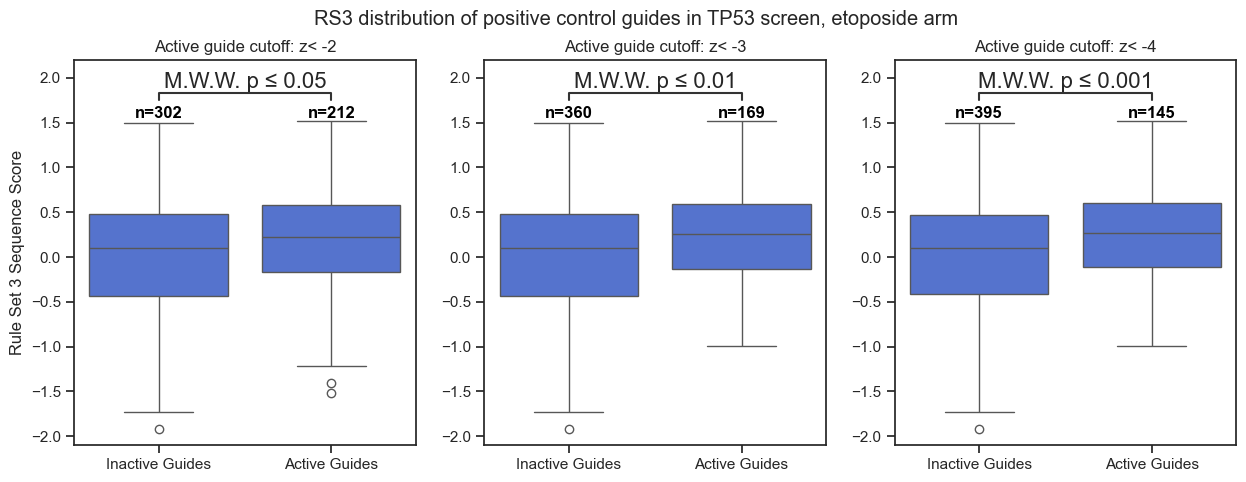

In [15]:
(fig,ax)=plt.subplots(1,3,figsize=(15,5))

plot_active_inactive(2,ax[0])
plot_active_inactive(3,ax[1])
plot_active_inactive(4,ax[2])

plt.suptitle("RS3 distribution of positive control guides in TP53 screen, etoposide arm")
ax[0].set_ylabel("Rule Set 3 Sequence Score")

#gpp.savefig("RS3_active_inactiveguides_TP53activitybased.pdf",bbox_inches="tight",dpi=600)